In [1]:
%matplotlib notebook

# 泰坦尼克获救情况分析
https://www.kaggle.com/c/titanic

## 数据描述

- PassengerId：乘客ID
- Survived：是否获救了
- Pclass：几等仓
- Name：姓名
- Sex：性别
- Age：年龄
- SibSp:兄弟姐妹数量
- Parch:带了几个老人孩子
- Ticket:船的编号
- Fare：买船票花费
- Cabin：有大量缺失值
- Embarked：


## 数据预处理

In [3]:
import pandas
titanic = pandas.read_csv("titanic_train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(titanic.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


上面的描述是：
- count:数量
- mean：均值
- std: 标准方差
- min:最小值
- 25%: 25%位置的值
- 50%：中值
- 75%：75%位置的值
- max：最大值

我们看到Age列数量只有714个，是因为有缺失值。

### 缺失值处理
对于缺失值，我们需要对其进行处理。这里可以来添加中值

In [6]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
print(titanic.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


### 非数字的处理
对于性别，只有男性和女性。我们需要转换为数值，可以转化成int或者float。这里我们把0表示male, 1表示female。
首先，我们来看Sex列有几种值

In [7]:
print(titanic["Sex"].unique())

['male' 'female']


In [8]:
# 对男女进行编号
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

除了Sex字段，还有Embarked也不是数值的，我们也需要进行转换

In [9]:
print(titanic["Embarked"].unique())
titanic["Embarked"] = titanic["Embarked"].fillna('S')
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['S' 'C' 'Q' nan]


String值得填充我们是用多的填，这里$S$最多，因此用它填。
现在我们数据预处理结束后，可以做二分类看看到底是获救了还是没获救。
最简单的方法是线性回归。

## 回归模型
加入有100个样本，现在我们怎么衡量。我们一部分用作训练集，一部分用作测试集。
交叉验证(Cross_Validation），我们将训练集分为多分，比如三分，用1、2号做训练，3号做测试，然后用1、3训练，2号验证，多次这样，我们得到三个模型，然后对它们进行平均和。通过交叉验证，使得结果更趋于平均化。这就是引入交叉验证的意义。

In [13]:
# import the linear regression class
from sklearn.linear_model import LinearRegression
# 交叉验证
from sklearn.cross_validation import KFold

# 选择特征
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Initialize our algorithm class
alg = LinearRegression()
# titanic.shape返回[m, n]，m是多少个；n_folds做几倍的交叉验证;random_state表示每次切分都是相同的
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    #先拿到特征
    train_predictors = (titanic[predictors].iloc[train, :])
    #拿到真实的label
    train_target = titanic["Survived"].iloc[train]
    #用线性回归应用到数据上
    alg.fit(train_predictors, train_target)
    #训练完了就可以做预测了
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

D:\apps\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


用pandas和sklearn做机器学习还是很简单的，流程就是：处理数据->选择特征->选择算法->多次交叉验证->最后把结果给append进来。
线性回归得到我们的结果是在区间$[0,1]$上的某一个值，我们怎么把区间值转换为类别呢？我们可以认为小于0.5认为是没获救，大于0.5认为获救了。

In [14]:
import numpy as np

# 预测在3个分开的numpy array中。把它合并在一起。
# 我们在axis 0上拼接它们。因为它们只有一个轴。
predictions = np.concatenate(predictions, axis=0)

predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0
accuracy = sum(predictions[predictions == titanic['Survived']]) / len(predictions)
print(accuracy)

0.783389450056


D:\apps\anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


模型准确率是拿预测准确的值除以总的预测结果。我们的准确率是0.78，比全靠蒙的50%高不了多少。我们可以使用更高级的算法。逻辑回归能够直接得出某只的概率。

In [16]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression(random_state = 1)
#计算每个交叉验证的准确值
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
#获取均值
print(scores.mean())

0.787878787879


虽然叫逻辑回归，但是我们一般用它做分类。现在的结果还是0.78多。

## 随机森林模型
随机：
1. 取样随机，每次取样是又放回的取样
2. 选择特征也是随机的选择

森林：
决策树有可能不准，我们用多个树来分类。最终结果取多个决策树的随机值。

就我们这个例子来说，我们用随机森林能够防止过拟合，使得算法得到的准确性更可靠。

In [17]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# n_estimators 是我们想构造的树数量
# min_samples_split 节点进行分裂，最小的节点数量
# min_samples_leaf 最小叶子节点个数
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=kf)

print(scores.mean())

0.785634118967


我们看到样本只有0.78的数量，这是因为我们的随机森林个数偏少的原因。我们可以增加决策树来试试，并且决策树也更深一些。

In [18]:
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=4, min_samples_leaf=2)
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=kf)

print(scores.mean())

0.81593714927


现在我们看到决策树的准确率到了0.81了。这也说明参数的调节也非常重要。

我们知道，一个机器学习的项目不可能特征这么明显，我们需要做的第一件事情就是提取特征。现在我们能不能再提取一些别的项目。比如我们来看家庭成员数量，数量越多说不定逃生几率越大。

然后我们看看名字长短是不是也有关系。

In [20]:
# 生成家庭列
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# apply方法用来产生新的series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

还有就是名字当中含有的一些职业属性，也可以提取出来作为一种特征。

In [25]:
import re

# 从名字中获取title
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

title_mapping = {"Mr": 1, "Miss": 2, "Mrs":3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Mlle": 8, "Col": 9, "Capt": 10, "Ms": 11,
                "Don": 12, "Sir": 13, "Lady": 14, "Johkheer": 15, "Countess": 16, "Mme": 17, "Jonkheer": 18}
for k, v in title_mapping.items():
    titles[titles==k] = v

print(pandas.value_counts(titles))

titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Capt          1
Ms            1
Don           1
Sir           1
Lady          1
Jonkheer      1
Countess      1
Mme           1
Name: Name, dtype: int64
1     517
2     182
3     125
4      40
5       7
6       6
8       2
7       2
9       2
17      1
10      1
11      1
12      1
13      1
14      1
16      1
18      1
Name: Name, dtype: int64


## 特征选择
Feature importance。每个特征的作用有多大，我们需要关注一下。我们有891个数据，我们用随机森林有放回采样，那肯定还有很多没有采到的数据，假如我们做了800次有放回采样，其中有300个没有采过。我们叫这800个数据为in bag数据（袋内数据），300个叫out of bag数据（代外数据）。那么我们就能拿这300个数据做测试数据了。
比如Age列，我们对这个列什么也不做，用来跑随机模型，看看错误率$error_1$。然后我们给这个列值加上一些噪音数据，同时保证其他列加上噪音值，然后再获得错误率$error_2$，如果$error_2$明显上升，表示Age列是非常重要的，如果没发生多大变化，表示Age列对最终结果没有多大影响。

<IPython.core.display.Javascript object>


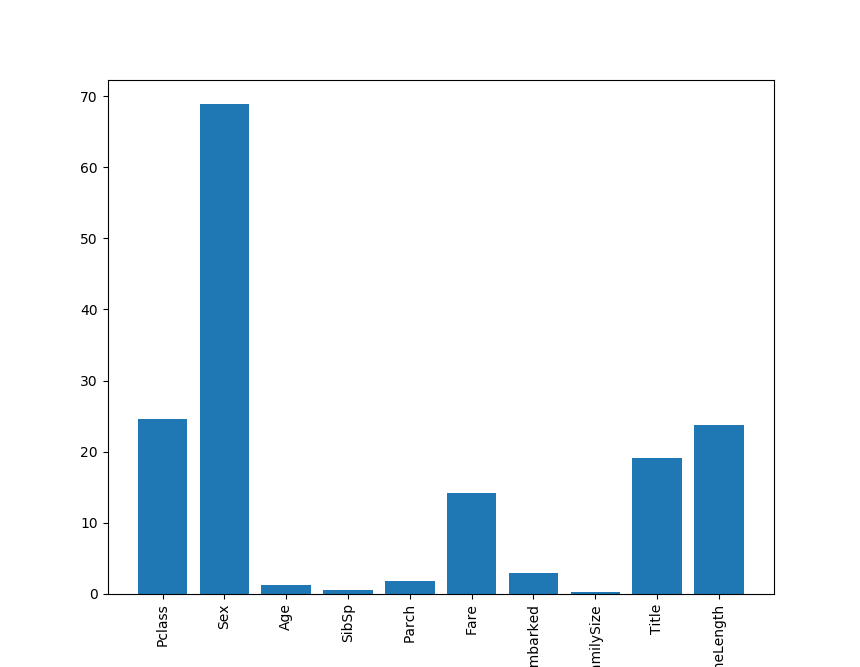

In [26]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'NameLength']

# 执行特征选择
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# 获得每个特征的原始p-Value，然后转换成值
scores = -np.log10(selector.pvalues_)

# 画出分值
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# 选出4个最佳特征
predictors = ['Pclass', 'Sex', 'Fare', 'Title']

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)

我们使用多个算法同时做。

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ['Pclass', 'Sex', 'Fare', 'FamilySize', 'Title', 'Age', 'Embarked']],
    [LogisticRegression(random_state=1), ['Pclass', 'Sex', 'Fare', 'FamilySize', 'Title', 'Age', 'Embarked']]
]

kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic['Survived'].iloc[train]
    full_test_predictions = []
    for alg, predictors in algorithms:
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # .astype(float) 用来转换DataFrame为浮点类型
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test, :].astype(float))[:, 1]
        full_test_predictions.append(test_predictions)
    # 两种算法平均，也可以加上权重
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

predictions = np.concatenate(predictions, axis=0)

accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.822671156004


D:\apps\anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
